In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (8, 6)

os.makedirs('../outputs', exist_ok=True)

In [2]:
# Constants

NUM_SEQUENCES = 121
DATA_PATH = './Challenge1-AM/DataBase/38Q31TzlO-{}/npz_data/data.npz'
PARAMS_PATH = './Challenge1-AM/DataBase/38Q31TzlO-{}/Minamo_Parameters-Wall2D.txt'
RANDOM_SEED = 20210831

In [3]:
# Data loading and parsing methods

def load_data(simulation_ids, recurrent=False):
    
    inputs, targets = [], []
    
    for simulation_id in simulation_ids:

        data = np.load(DATA_PATH.format(simulation_id))

        # Unused
        # T_top = data['T_top']
        # x = data['x']
        # y = data['y']
        # temperatures = data['temperatures']
        
        # Parse parameters
        with open(PARAMS_PATH.format(simulation_id)) as params_file:
            lines = params_file.read().splitlines()
            power = float(lines[0].split(' = ')[1])
            break_time = float(lines[1].split(' = ')[1])

        # Input data
        time = data['time']
        delta = time.copy()
        delta[1:] = time[1:] - time[:-1]
        laser_position = data['laser_position_x']
        laser_power = data['laser_power']
        power = np.full(laser_power.shape, power)
        break_time = np.full(laser_power.shape, break_time)
        if not recurrent:
            input = np.stack([time, laser_position, laser_power, power, break_time], axis=1)
        else:
            input = np.stack([time, power, break_time, delta, laser_position, laser_power], axis=1)

        # Target data
        target = np.stack([data['T{}'.format(i + 1)] for i in range(6)], axis=1)
        
        # TODO: delete this
        if recurrent:
            input = input[::20, :]
            target = target[::20, :]

        inputs.append(input)
        targets.append(target)
    
    if not recurrent:
        inputs = np.concatenate(inputs, axis=0)
        targets = np.concatenate(targets, axis=0)
        
        
    else:
        max_len = max(input.shape[0] for input in inputs)
        
        for i, input in enumerate(inputs):
            inputs[i] = np.pad(input, [(0, max_len - input.shape[0]), (0, 0)])
        for i, target in enumerate(targets):
            targets[i] = np.pad(target, [(0, max_len - target.shape[0]), (0, 0)])
        
        inputs = np.stack(inputs, axis=1)
        targets = np.stack(targets, axis=1)
    
    return inputs.astype(np.float32), targets.astype(np.float32)

In [4]:
np.random.seed(RANDOM_SEED)
permutation = np.random.permutation(np.arange(1, NUM_SEQUENCES + 1))
first_split = int(0.7 * NUM_SEQUENCES)
second_split = int(0.85 * NUM_SEQUENCES)
train_sequence_ids = permutation[:first_split]
valid_sequence_ids = permutation[first_split:second_split]
test_sequence_ids = permutation[second_split:]

In [5]:
train_inputs, train_targets = load_data(train_sequence_ids, recurrent=True)
valid_inputs, valid_targets = load_data(valid_sequence_ids, recurrent=True)
test_inputs, test_targets = load_data(test_sequence_ids, recurrent=True)

In [6]:
train_inputs.shape

(148, 84, 6)

In [7]:
train_targets.shape

(148, 84, 6)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
X_train = tf.convert_to_tensor(train_inputs)
X_train = tf.transpose(X_train, perm=[1, 0, 2])

y_train = tf.convert_to_tensor(train_targets)
y_train = tf.transpose(y_train, perm=[1, 0, 2])

X_val = tf.convert_to_tensor(valid_inputs)
X_val = tf.transpose(X_val, perm=[1, 0, 2])

y_val = tf.convert_to_tensor(valid_targets)
y_val = tf.transpose(y_val, perm=[1, 0, 2])

X_test = tf.convert_to_tensor(test_inputs)
X_test = tf.transpose(X_test, perm=[1, 0, 2])

y_test = tf.convert_to_tensor(test_targets)
y_test = tf.transpose(y_test, perm=[1, 0, 2])

In [57]:
for i in X_train[40]:
    print(i)

tf.Tensor([ 2.5000e-02  1.9000e+02  1.0000e+00  2.5000e-02 -1.9875e+01  1.9000e+02], shape=(6,), dtype=float32)
tf.Tensor([ 5.2500e-01  1.9000e+02  1.0000e+00  2.5000e-02 -1.7375e+01  1.9000e+02], shape=(6,), dtype=float32)
tf.Tensor([ 1.0250e+00  1.9000e+02  1.0000e+00  2.5000e-02 -1.4875e+01  1.9000e+02], shape=(6,), dtype=float32)
tf.Tensor([ 1.5250e+00  1.9000e+02  1.0000e+00  2.5000e-02 -1.2375e+01  1.9000e+02], shape=(6,), dtype=float32)
tf.Tensor([ 2.025e+00  1.900e+02  1.000e+00  2.500e-02 -9.875e+00  1.900e+02], shape=(6,), dtype=float32)
tf.Tensor([ 2.525e+00  1.900e+02  1.000e+00  2.500e-02 -7.375e+00  1.900e+02], shape=(6,), dtype=float32)
tf.Tensor([ 3.025e+00  1.900e+02  1.000e+00  2.500e-02 -4.875e+00  1.900e+02], shape=(6,), dtype=float32)
tf.Tensor([ 3.525e+00  1.900e+02  1.000e+00  2.500e-02 -2.375e+00  1.900e+02], shape=(6,), dtype=float32)
tf.Tensor([4.025e+00 1.900e+02 1.000e+00 2.500e-02 1.250e-01 1.900e+02], shape=(6,), dtype=float32)
tf.Tensor([4.525e+00 1.900e+

In [10]:
X_train.shape

TensorShape([84, 148, 6])

In [11]:
y_train.shape

TensorShape([84, 148, 6])

In [12]:
X_input =tf.keras.Input(shape=(X_train.shape[1],X_train.shape[2]))


X = layers.SimpleRNN(84, return_sequences=True, activation="selu", 
                     kernel_initializer=tf.keras.initializers.lecun_normal(
                        seed=RANDOM_SEED
                    ))(X_input)
X = layers.GRU(256,
                     return_sequences=True,
                     activation="selu", 
                     kernel_initializer=tf.keras.initializers.lecun_normal(
                        seed=RANDOM_SEED
                    )
                )(X)


X = layers.SimpleRNN(84, return_sequences=True, activation="selu", 
                     kernel_initializer=tf.keras.initializers.lecun_normal(
                        seed=RANDOM_SEED
                    ))(X)

X = layers.AlphaDropout(0.7, seed=RANDOM_SEED)(X)

X = layers.Dense(6, 
                 activation="selu", 
                 kernel_initializer=tf.keras.initializers.lecun_normal(
                    seed=RANDOM_SEED
                ))(X)

model = tf.keras.Model(inputs=X_input, outputs=X)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 148, 6)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 148, 84)           7644      
_________________________________________________________________
gru (GRU)                    (None, 148, 256)          262656    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 148, 84)           28644     
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 148, 84)           0         
_________________________________________________________________
dense (Dense)                (None, 148, 6)            510       
Total params: 299,454
Trainable params: 299,454
Non-trainable params: 0
_______________________________________________________

In [13]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer="adam",
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [21]:
x_train_over = X_train
#for i in range(1,6):
#    x_train_over = tf.concat((x_train_over,x_train_over), axis=0)
#print(x_train_over.shape)

y_train_over = y_train
#for i in range(1,6):
#    y_train_over = tf.concat((y_train_over,y_train_over), axis=0)
#y_train_over.shape

In [28]:
model.fit(x_train_over, y_train_over, validation_data=(x_train_over,y_train_over), batch_size=64, epochs = 20, verbose=1)

Train on 84 samples, validate on 84 samples
Epoch 1/20
84/84 [==============================] - 1s 7ms/sample - loss: 21034.9929 - root_mean_squared_error: 145.0346 - val_loss: 992278.0685 - val_root_mean_squared_error: 996.1315
Epoch 2/20
84/84 [==============================] - 1s 7ms/sample - loss: 21763.4544 - root_mean_squared_error: 147.5245 - val_loss: 1269408.0714 - val_root_mean_squared_error: 1126.6801
Epoch 3/20
84/84 [==============================] - 1s 7ms/sample - loss: 21573.2773 - root_mean_squared_error: 146.8786 - val_loss: 892025.5655 - val_root_mean_squared_error: 944.4710
Epoch 4/20
84/84 [==============================] - 1s 7ms/sample - loss: 22152.8962 - root_mean_squared_error: 148.8387 - val_loss: 1311390.4524 - val_root_mean_squared_error: 1145.1597
Epoch 5/20
84/84 [==============================] - 1s 8ms/sample - loss: 22259.9659 - root_mean_squared_error: 149.1979 - val_loss: 970896.5327 - val_root_mean_squared_error: 985.3406
Epoch 6/20
84/84 [=========

In [23]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 2ms/sample - loss: 1045692.5625 - root_mean_squared_error: 1022.5912


[1045692.5625, 1022.5912]

plot train

In [30]:
pred = model.predict(X_train)

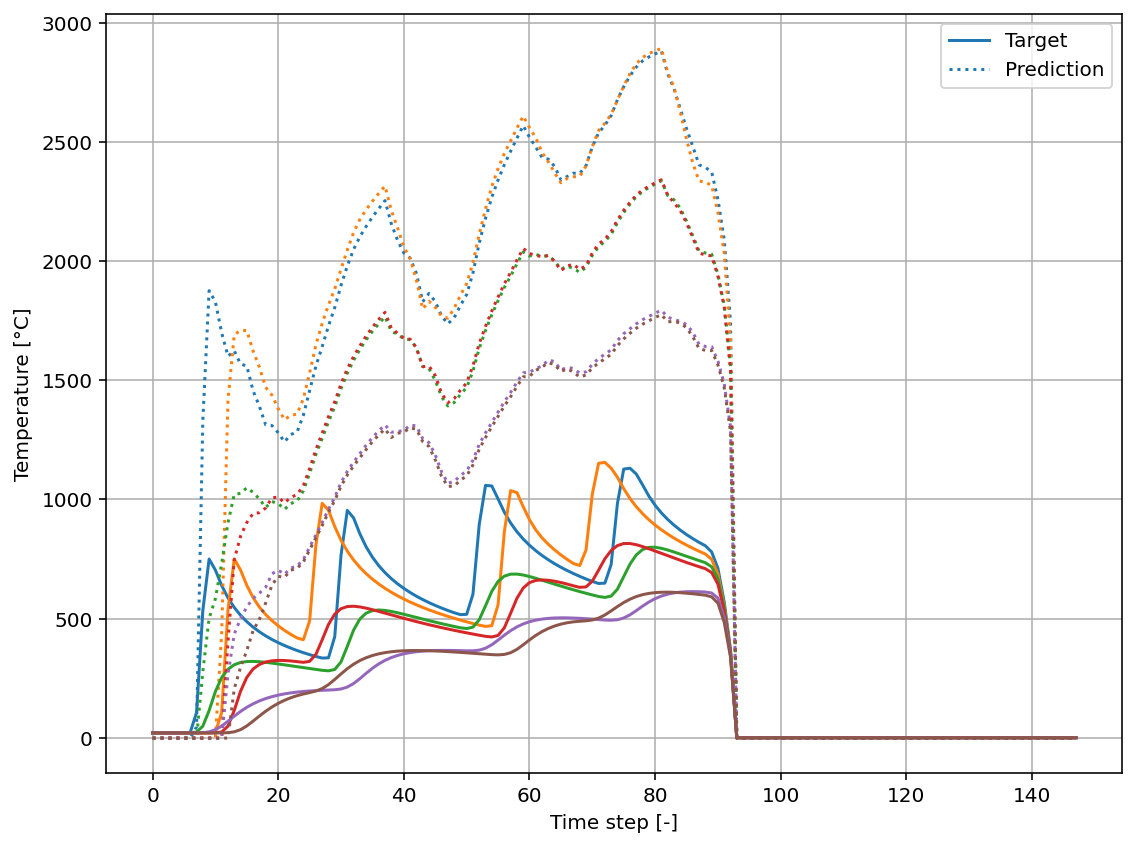

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()
for i in range(6):
    ax.plot(y_train[0, :, i], color='C{}'.format(i), label='Target')
    ax.plot(pred[0, :, i], color='C{}'.format(i), linestyle=':', label='Prediction')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
ax.legend(handles, labels)
ax.set_xlabel('Time step [-]')
ax.set_ylabel('Temperature [°C]')
plt.tight_layout()
plt.show()

In [26]:
pred_test = model.predict(X_test)

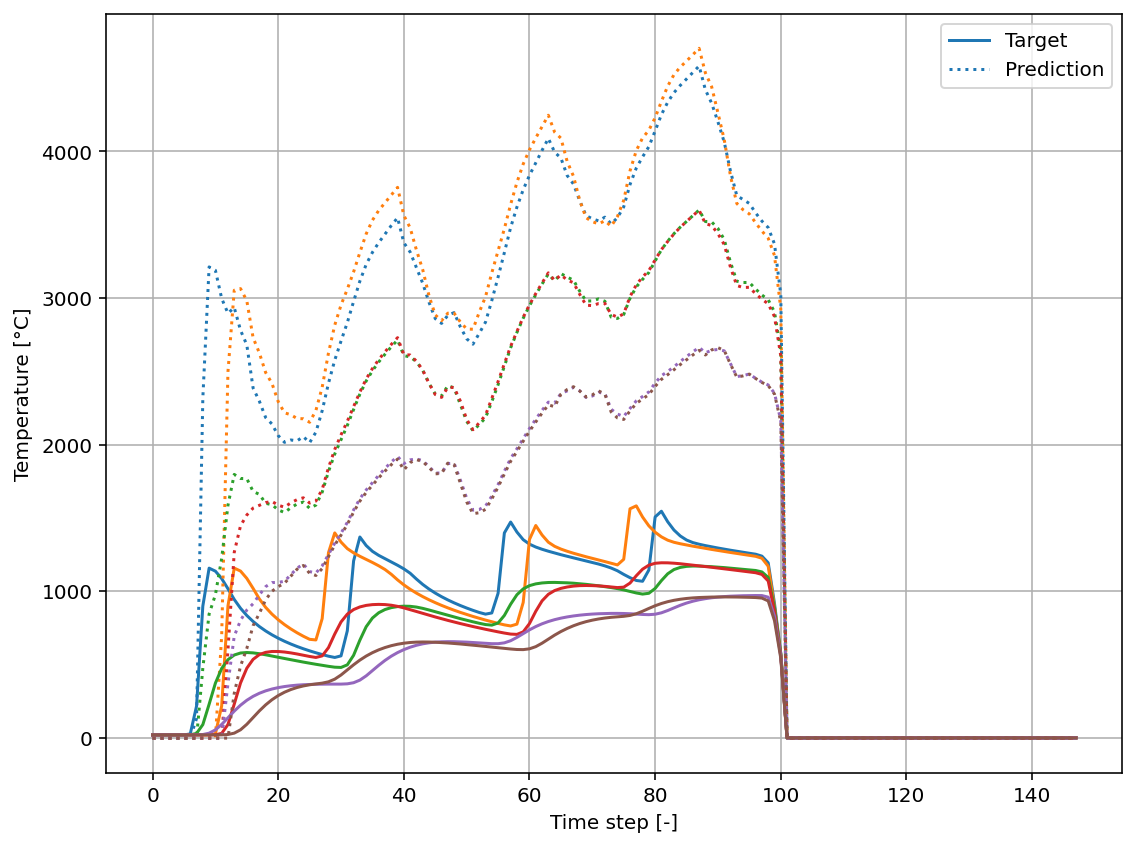

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()
for i in range(6):
    ax.plot(y_test[0, :, i], color='C{}'.format(i), label='Target')
    ax.plot(pred_test[0, :, i], color='C{}'.format(i), linestyle=':', label='Prediction')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
ax.legend(handles, labels)
ax.set_xlabel('Time step [-]')
ax.set_ylabel('Temperature [°C]')
plt.tight_layout()
plt.show()